# Credit Risk Analysis

## 1. Data Loading

Import libraries, start a Spark Session and load the clean, processed dataset.

In [8]:
# --- Imports ---
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_theme(style='whitegrid')
pd.set_option('display.max_columns', 50)

In [9]:
# --- Initialize Spark Session ---
def init_spark():
    return (
        SparkSession.builder
        .appName("CreditApprovalEDA")
        .config("spark.driver.memory", "4g")
        .getOrCreate()
    )
spark = init_spark()

In [10]:
# --- Load the Processed Data ---
PROCESSED_DATA_PATH = "../data/processed/primary_dataset"

print(f"Loading data from: {PROCESSED_DATA_PATH}")
df = spark.read.parquet(PROCESSED_DATA_PATH)

df.cache()

Loading data from: ../data/processed/primary_dataset


25/07/05 19:54:18 WARN CacheManager: Asked to cache already cached data.


DataFrame[ID: int, CODE_GENDER: string, FLAG_OWN_CAR: string, FLAG_OWN_REALTY: string, CNT_CHILDREN: int, AMT_INCOME_TOTAL: double, NAME_INCOME_TYPE: string, NAME_EDUCATION_TYPE: string, NAME_FAMILY_STATUS: string, NAME_HOUSING_TYPE: string, DAYS_BIRTH: int, DAYS_EMPLOYED: int, FLAG_MOBIL: int, FLAG_WORK_PHONE: int, FLAG_PHONE: int, FLAG_EMAIL: int, OCCUPATION_TYPE: string, CNT_FAM_MEMBERS: double, Risk_Flag: int]

In [11]:
# --- Initial Inspection ---
print(f"Dataset loaded successfully. It has {df.count()} rows and {len(df.columns)} columns.")
print("\n--- Schema ---")
df.printSchema()

print("\n--- Sample Data ---")
df.limit(5).toPandas()

Dataset loaded successfully. It has 36457 rows and 19 columns.

--- Schema ---
root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- Risk_Flag: integer (nullable = true)


--- Sample Data ---


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Risk_Flag
0,5089051,M,N,N,0,225000.0,Working,Higher education,Married,House / apartment,-13231,-3139,1,1,1,0,Sales staff,2.0,0
1,5125602,F,Y,Y,0,450000.0,Commercial associate,Higher education,Married,House / apartment,-10149,-2783,1,0,0,0,Accountants,2.0,0
2,5047848,M,Y,Y,0,315000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-21871,-979,1,0,0,0,Drivers,2.0,0
3,5009994,M,Y,Y,1,360000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-13940,-617,1,0,0,0,Managers,3.0,0
4,5066783,M,Y,N,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-15567,-2014,1,0,0,0,Drivers,3.0,0


## 2. Target Variable Analysis

Understand the distribution of the `Risk_Flag`.

In [12]:
target_distro = df.groupBy("Risk_Flag").count().orderBy("Risk_Flag").toPandas()
target_distro['percentage'] = target_distro['count'] / target_distro['count'].sum() * 100

print(target_distro)

   Risk_Flag  count  percentage
0          0  35841   98.310338
1          1    616    1.689662


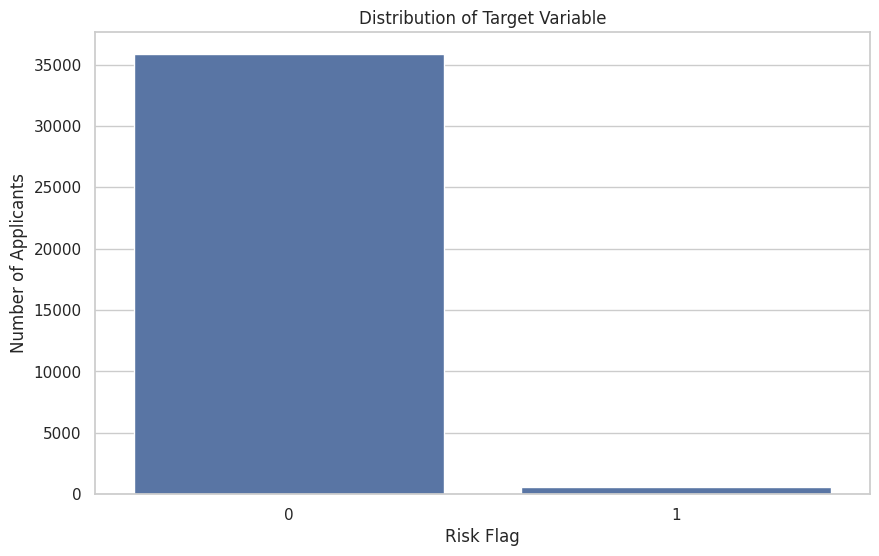

In [13]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=target_distro, x='Risk_Flag', y='count')
plt.title('Distribution of Target Variable')
plt.xlabel('Risk Flag')
plt.ylabel('Number of Applicants')

plt.show()

Observation:
- The dataset is extremely imbalanced. High-risk applicants (Risk_Flag = 1) make up a minority of the dataset (~2%).
- Implication: 
    - Model accuracy will be a useless metric. We should focus on metrics like AUC-ROC, Precision, Recall, and the F1-score. 
    - We will also need to use techniques to handle this imbalance during modeling, such as SMOTE.

## 3. Analysis of Categorical Features

Understand the composition of all applicants bases on key categorical variables and observe their relationships with risk.

  CODE_GENDER  Total_Count  Risk_Rate
0           M        12027   0.019706
1           F        24430   0.015514


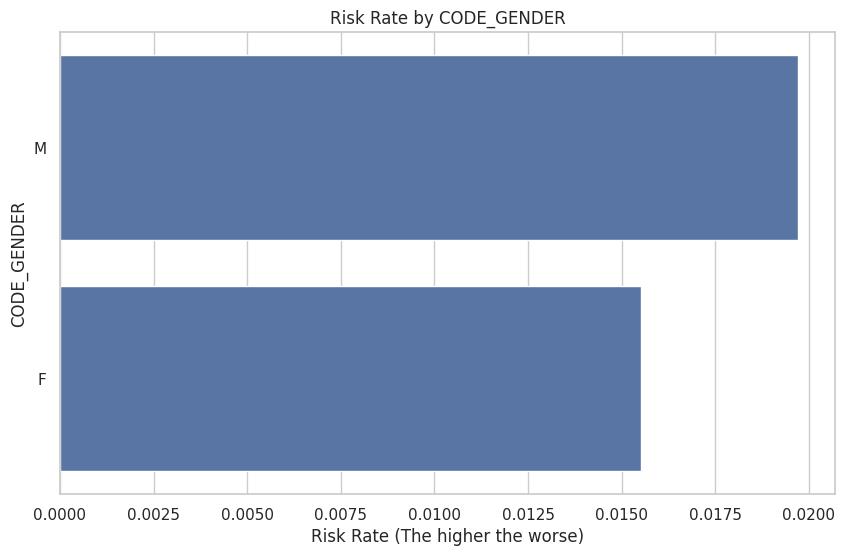

  FLAG_OWN_CAR  Total_Count  Risk_Rate
0            N        22614   0.017334
1            Y        13843   0.016181


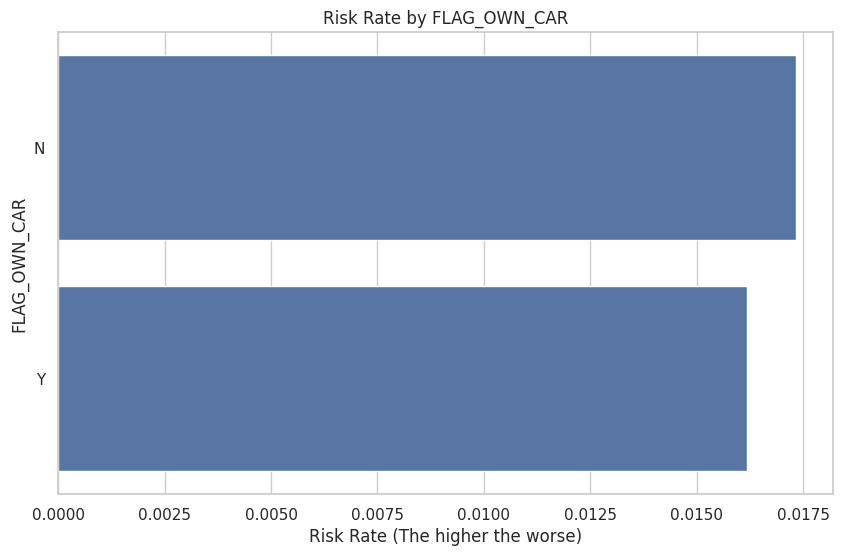

  FLAG_OWN_REALTY  Total_Count  Risk_Rate
0               N        11951   0.021002
1               Y        24506   0.014894


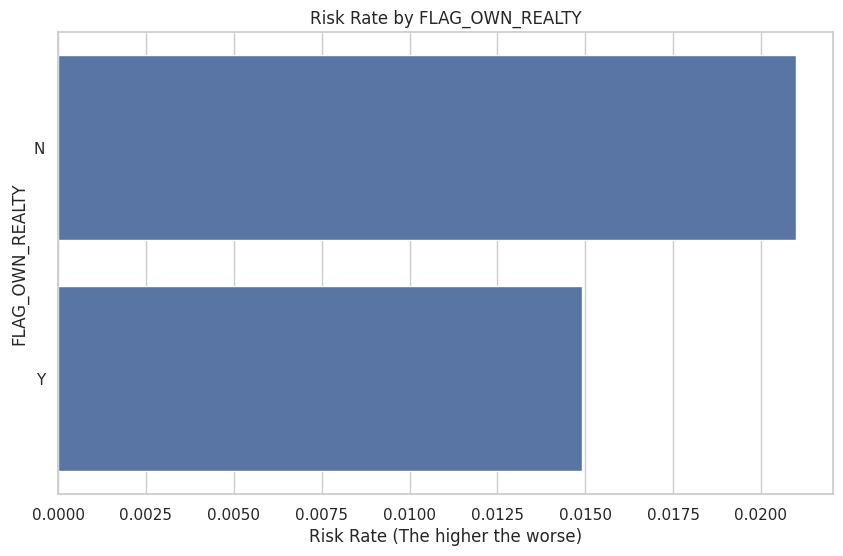

       NAME_INCOME_TYPE  Total_Count  Risk_Rate
0             Pensioner         6152   0.021131
1  Commercial associate         8490   0.016843
2               Working        18819   0.016260
3         State servant         2985   0.012395
4               Student           11   0.000000


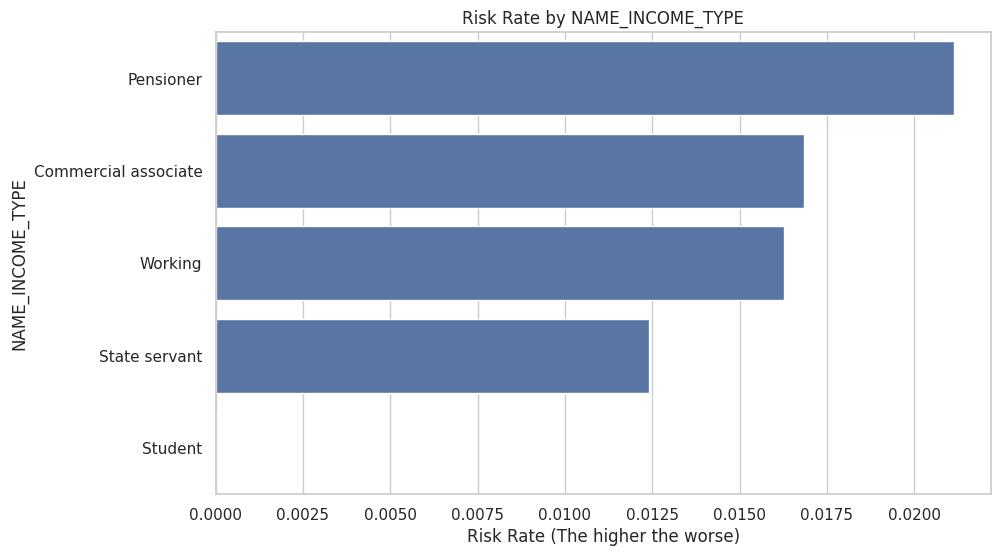

             NAME_EDUCATION_TYPE  Total_Count  Risk_Rate
0                Lower secondary          374   0.026738
1              Incomplete higher         1410   0.023404
2               Higher education         9864   0.017336
3  Secondary / secondary special        24777   0.016225
4                Academic degree           32   0.000000


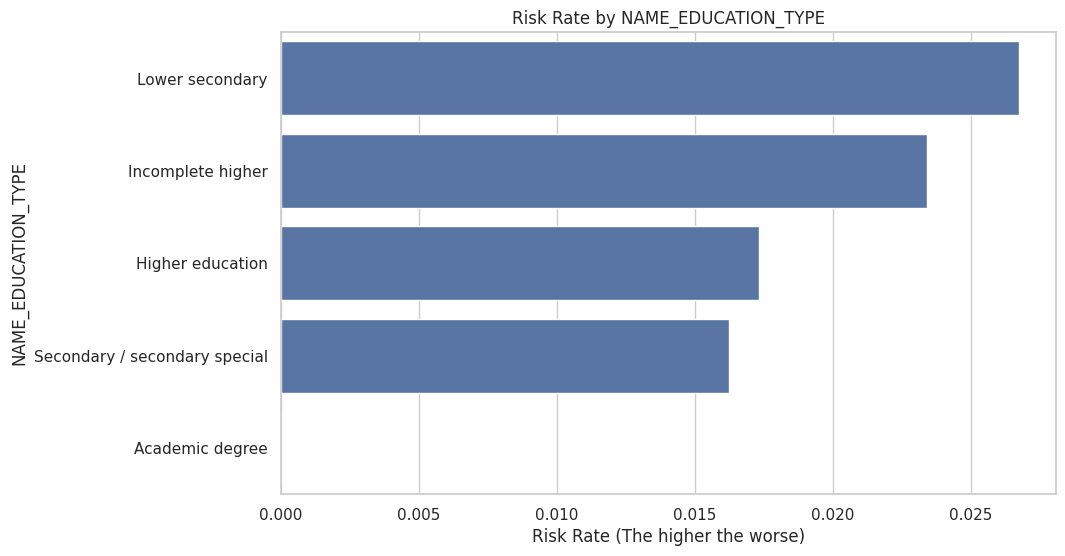

     NAME_FAMILY_STATUS  Total_Count  Risk_Rate
0                 Widow         1532   0.029373
1  Single / not married         4829   0.020915
2               Married        25048   0.015690
3        Civil marriage         2945   0.015620
4             Separated         2103   0.014741


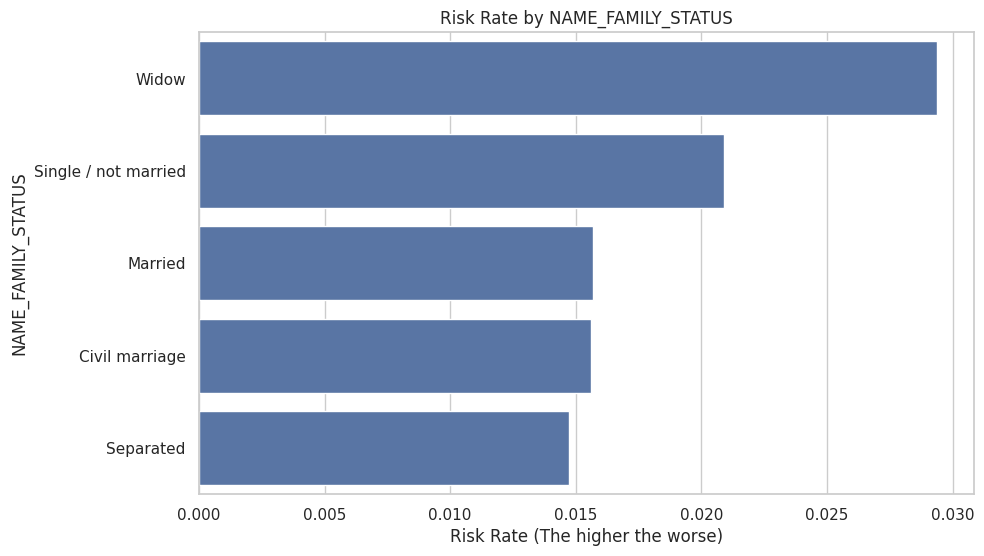

     NAME_HOUSING_TYPE  Total_Count  Risk_Rate
0     Office apartment          262   0.034351
1  Municipal apartment         1128   0.026596
2      Co-op apartment          168   0.017857
3    House / apartment        32548   0.016591
4         With parents         1776   0.014640
5     Rented apartment          575   0.013913


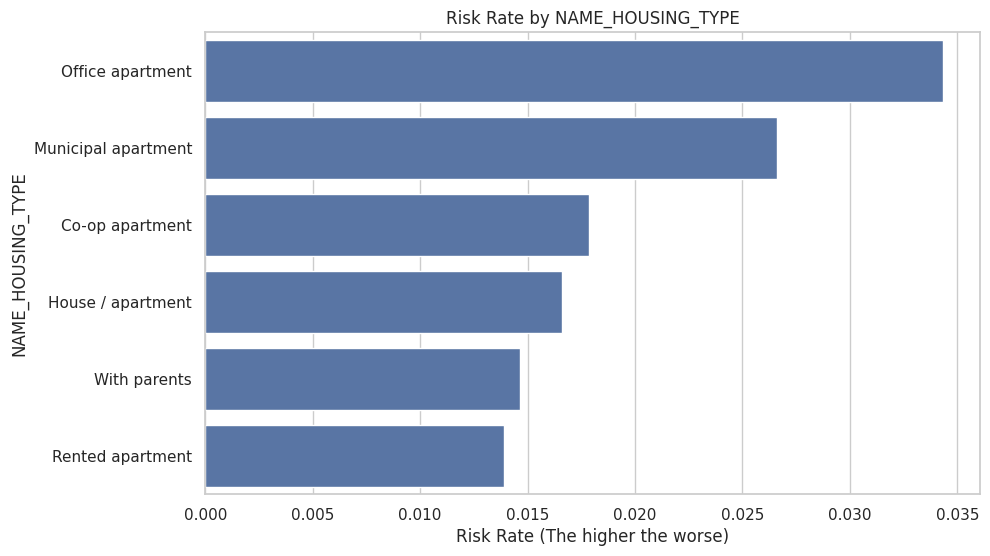

          OCCUPATION_TYPE  Total_Count  Risk_Rate
0                IT staff           60   0.050000
1      Low-skill Laborers          175   0.045714
2                 Drivers         2138   0.022919
3          Security staff          592   0.021959
4   High skill tech staff         1383   0.021692
5              Core staff         3591   0.020607
6             Accountants         1241   0.018533
7                    None        11323   0.017133
8                Laborers         6211   0.015939
9                Managers         3012   0.015604
10          Cooking staff          655   0.013740
11            Secretaries          151   0.013245
12            Sales staff         3485   0.012912
13               HR staff           85   0.011765
14   Waiters/barmen staff          174   0.011494
15         Cleaning staff          551   0.009074
16         Medicine staff         1207   0.008285
17  Private service staff          344   0.005814
18          Realty agents           79   0.000000


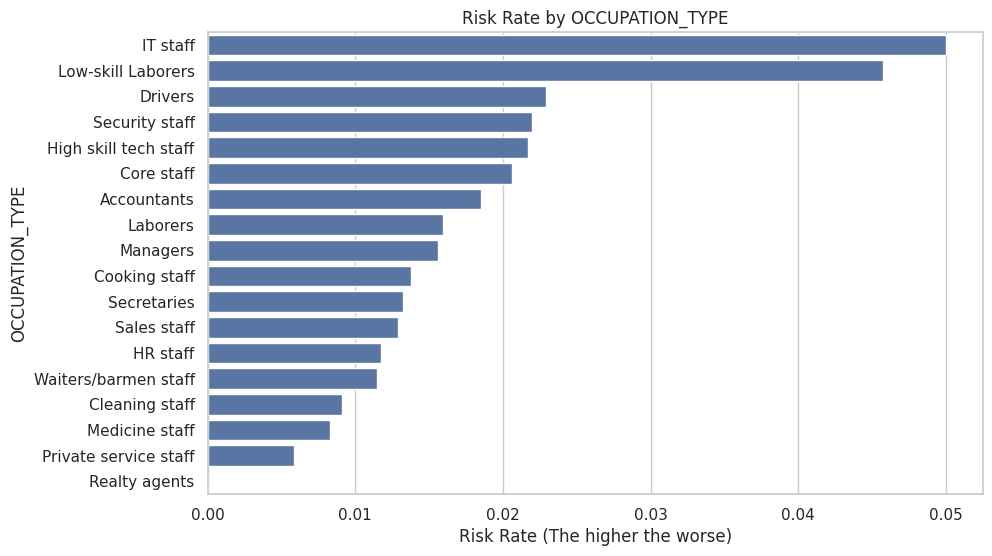

In [23]:
categorical_features = [
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE'
]

def plot_categorical(df, column):
    """Plot the risk rate for each category"""
    # Calculate the risk rate
    risk_rate_df = (
        df.groupBy(column)
        .agg(F.count("*").alias("Total_Count"), F.mean("Risk_Flag").alias("Risk_Rate"))
        .orderBy("Risk_Rate", ascending=False)
        .toPandas()
    )
    print(risk_rate_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=risk_rate_df, x="Risk_Rate", y=column, orient='h')
    plt.title(f"Risk Rate by {column}")
    plt.xlabel("Risk Rate (The higher the worse)")
    plt.show()

for feature in categorical_features:
    plot_categorical(df, feature)

Observation:
- Housing: People living in 'Rented apartments' or 'With parents' have a low risk rate.
- Education: There's a strong negative correlation. As education level increases ('Lower secondary' -> 'Academic degree'), the risk rate consistently decreases. This is a very strong signal.
- Income Type: 'Pensioners' show the highest risk rate, though counts might be low. 'State servant' seems to be a lower-risk type.
- Assets: Those who own assets (car, realty) have lower risk rate than those who don't.
- Gender: Male has a higher risk rate than female even though female count is twice its size. 

## 4. Analysis of Numerical Features

Explore the distribution of numerical features and observe the difference between high-risk vs. low-risk applicants.

In [29]:
# Create columns for age and years employed
df_eda = (df.withColumn("AGE", -F.col("DAYS_BIRTH") / 365.0)
            .withColumn("YEARS_EMPLOYED", F.when(F.col("DAYS_EMPLOYED") > 0, 0).otherwise(-F.col("DAYS_EMPLOYED") / 365.0))
        )
numerical_features = ["AMT_INCOME_TOTAL", "AGE", "YEARS_EMPLOYED", "CNT_FAM_MEMBERS"]

df_eda.select(numerical_features).describe().toPandas()

,summary,AMT_INCOME_TOTAL,AGE,YEARS_EMPLOYED,CNT_FAM_MEMBERS
0,count,36457,36457,36457,36457
1,mean,186685.73666236937,43.767598307783146,6.028266214166367,2.198452971994404
2,stddev,101789.2264823466,11.508356010299252,6.4843746908132625,0.9116861437101023
3,min,27000.0,20.517808219178082,0.0,1.0
4,max,1575000.0,68.90958904109588,43.04931506849315,20.0


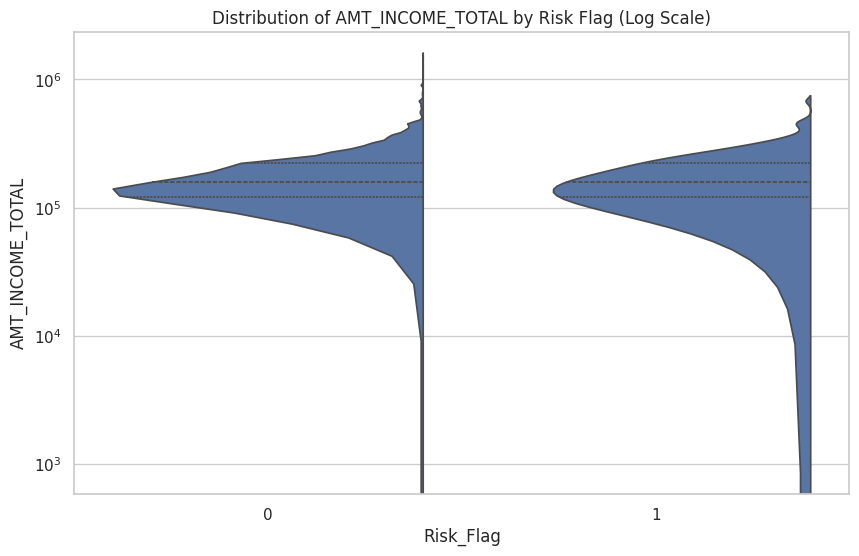

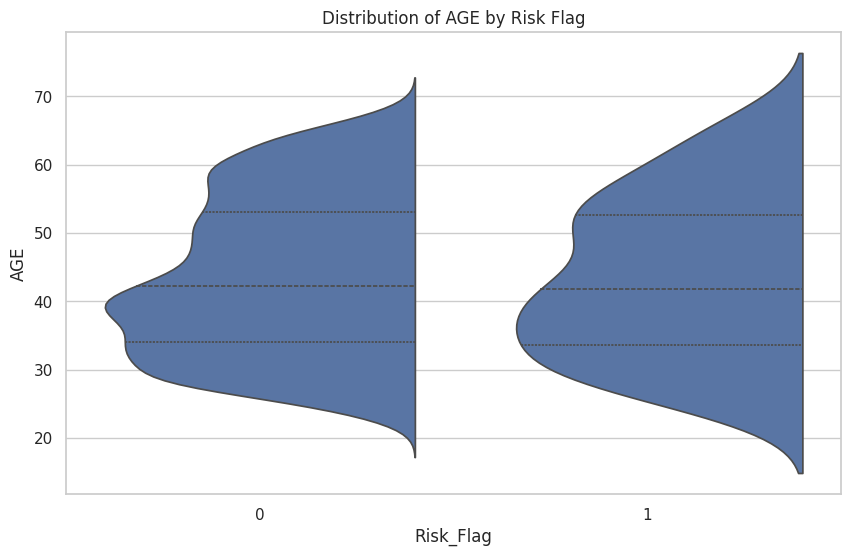

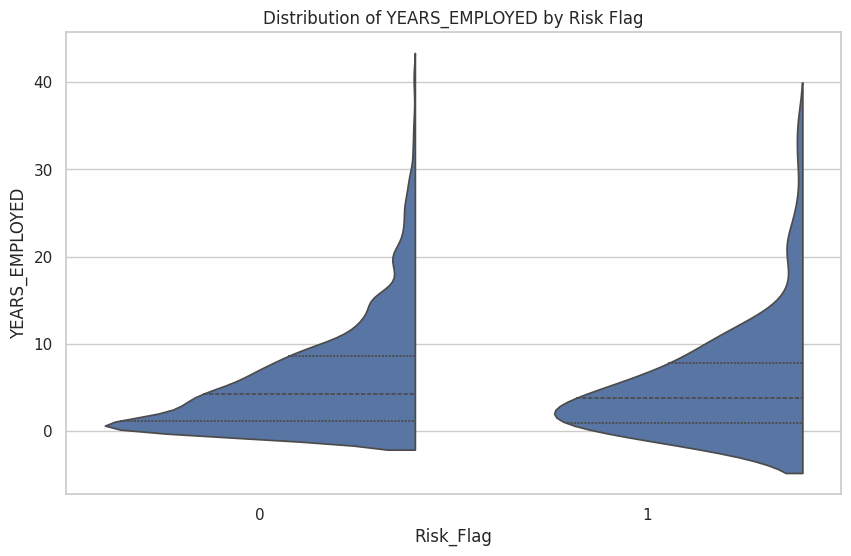

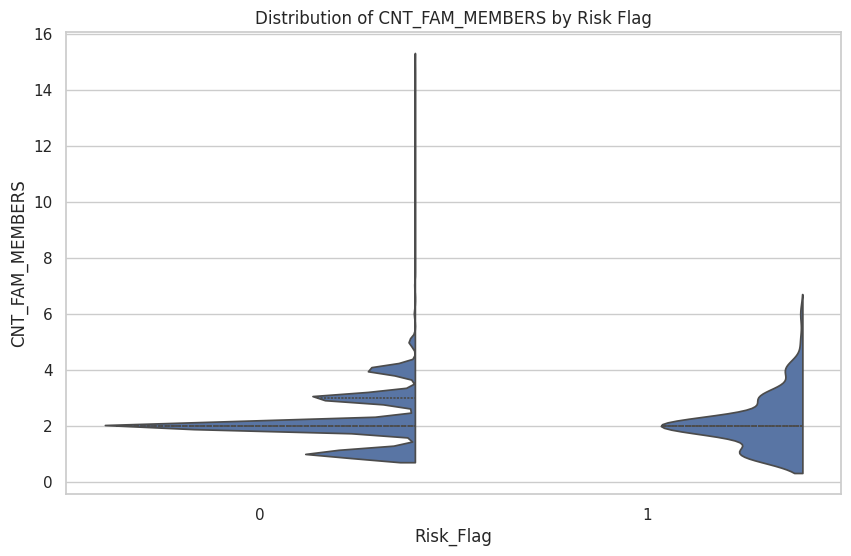

In [35]:
plot_sample_df = df_eda.select(numerical_features + ["Risk_Flag"]).sample(fraction=0.2, seed=42).toPandas()

for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=plot_sample_df, x="Risk_Flag", y=feature, split=True, inner="quartile")
    plt.title(f"Distribution of {feature} by Risk Flag")
    if feature == "AMT_INCOME_TOTAL":
        plt.yscale('log')
        plt.title(f"Distribution of {feature} by Risk Flag (Log Scale)")
    plt.show()

Observation:
- Age: The median age for high-risk applicants appears to be younger than for low-risk applicants. The distribution for low-risk applicants is wider, indicating they span a larger age range.
- Years Employed: Low-risk applicants tend to have been employed for longer.
- Income: The difference in income is not as visually striking. The log scale was necessary due to extreme outliers.

## 5. Temporarily Resample the Data for Visualization (Optional)

For some visualizations, it can be useful to create a temporary, balanced DataFrame just for plotting to reveal patterns. This should `NEVER` be used for model training or calculating final metrics.

Balanced sample has 1226 rows.
+---------+-----+
|Risk_Flag|count|
+---------+-----+
|        0|  610|
|        1|  616|
+---------+-----+



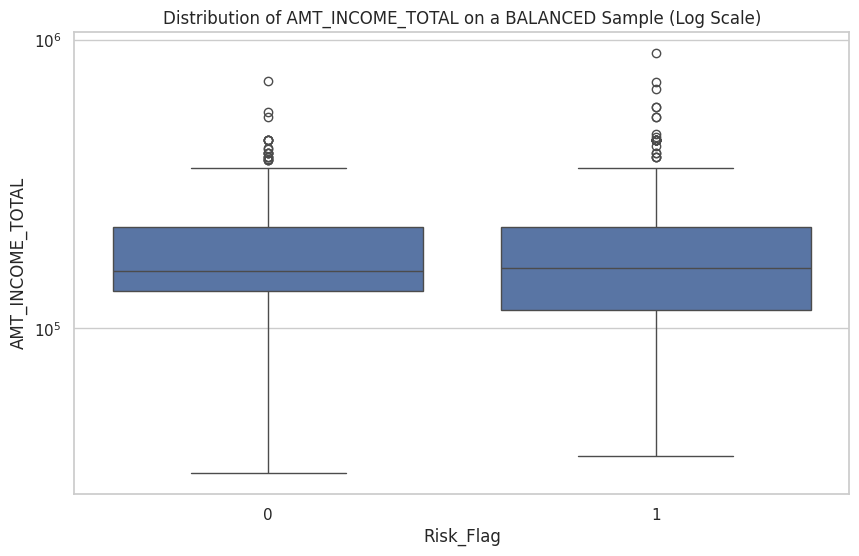

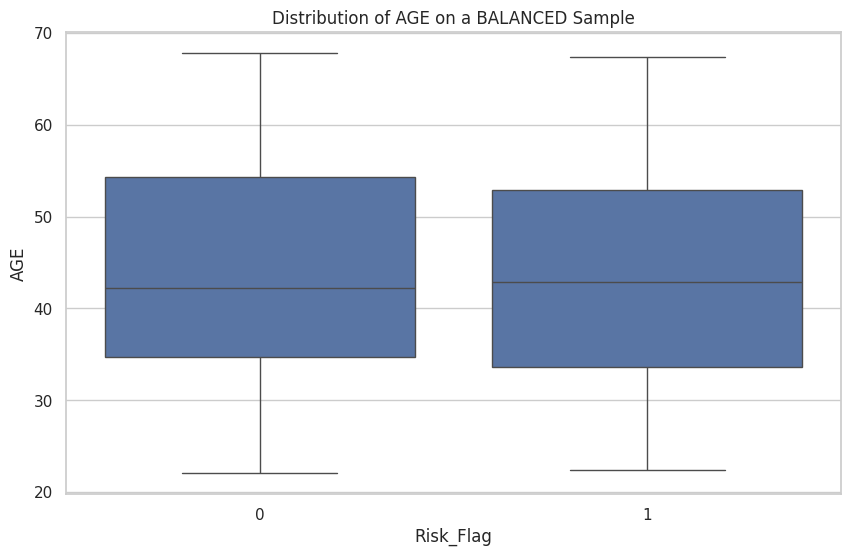

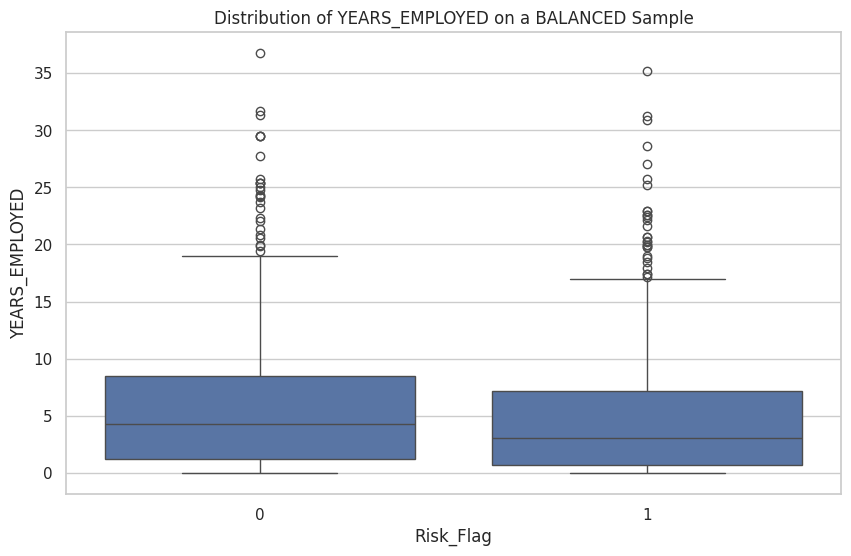

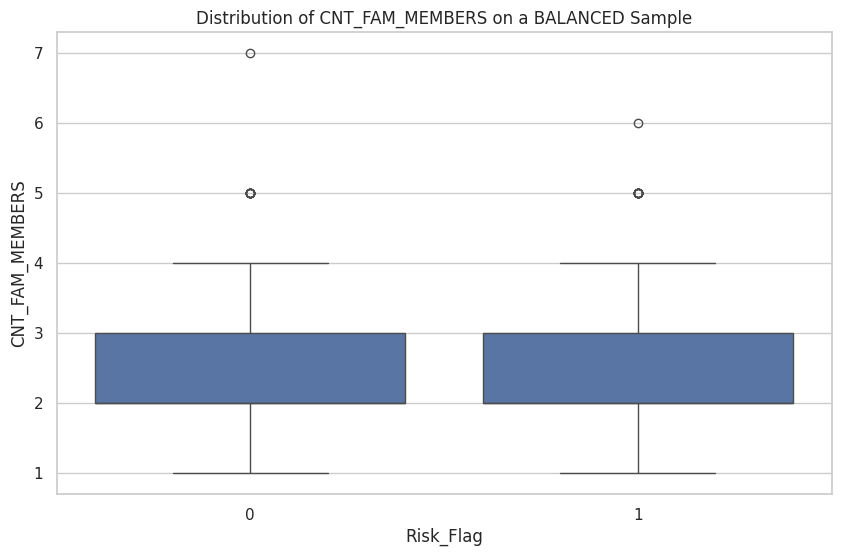

In [47]:
# Separate the two classes
df_majority = df_eda.filter(F.col("Risk_Flag") == 0)
df_minority = df_eda.filter(F.col("Risk_Flag") == 1)

# Undersample the majority class to match the minority class count
balanced_sample_df = df_majority.sample(
    withReplacement=False,
    fraction=df_minority.count() / df.count(), # This fraction will be very small
    seed=150
).union(df_minority)

print(f"Balanced sample has {balanced_sample_df.count()} rows.")
balanced_sample_df.groupBy("Risk_Flag").count().show()

# Re-create a boxplot on this balanced data
balanced_pandas = balanced_sample_df.select(numerical_features + ["Risk_Flag"]).toPandas()

for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=balanced_pandas, x="Risk_Flag", y=feature)
    plt.title(f"Distribution of {feature} on a BALANCED Sample")
    if feature == "AMT_INCOME_TOTAL":
        plt.yscale('log')
        plt.title(f"Distribution of {feature} on a BALANCED Sample (Log Scale)")
    plt.show()